# Building Bioinformatics Workflows with Snakemake

# Workflow Basics

Once you have all of your rules, you define the workflow by the desired outputs. Snakemake then back fills all the rules that must be run, depending on the inputs and outputs of each rule, to get to the user-specified outputs.

To run a workflow from the command line, the basic syntax is

```bash
snakemake --snakefile snakefile --use-conda --conda-frontend conda --configfile config.yaml --cores 1

```

<ul>
    <li>You MUST specify the number of cores, otherwise snakemake will throw an error.</li>
    <li>If you are using the mamba package manager <code>mamba</code>, replace <code>--conda-frontend conda</code> with <code>--conda-frontend mamba</code>.</li>
</ul>

In the above code, I specified the snakefile and config file to use. You can also change things like the home directory for a workflow (so all relative paths will be relative to this directory) with the `--directory` flag and specify a different directory where conda environments are stored than in this home directory with the `--conda-prefix` flag.

You can also set the maximum available RAM with something like `--resources mem_mb=8000`, meaning that there are 8 GB of RAM available. 

We won't use them, but there are some additional helpful flags:

<ul>
    <li><code>--unlock</code>: Snakemake locks a directory in which a workflow is running, so you can not run multiple workflows from the same directory to prevent potential conflicts in the output files. The directory is unlocked once the process completes. Use this flag to unlock a directory, for example, if a process was interrupted.</li>
    <li><code>--rerun-incomplete</code>: If a snakemake process is interrupted and some steps (jobs) only partially finished, rerun those</li>
    <li><code>--keep-going</code>: If one job fails, but there are other jobs that do not rely on its outputs, run them. This is useful if you have many samples, and one fails, but the workflow can continue processing the others.</li>
    <li><code>--dry-run</code>: Perform a dry run of the worfklow to ensure that the graph of jobs is valid and that all required inputs are present.</li>
</ul>

# Activity: Short-Read Processing and Classification for <i>M. tuberculosis</i>

In this short activity, we will download short-read whole-genome sequencing for <i>Mycobacterium tuberculosis</i>, perform quality-control, and perform taxonomic classification.

To get a pure bacterial sample, typically a sputum sample (coughed up by patients with respiratory infections) is cultured to select for the pathogen of interest. However, this loses some microbial diversity because the population is heterogeneous. There may be different <i>M. tuberculosis</i> clones in a single patient.

Therefore, the sample we will be working with has been sequenced directly from sputum, without the culturing step, which leads to more DNA contaminants from

<ul>
    <li>Host (human)</li>
    <li>Lung commensal bacteria</li>
    <li>Environmental bacteria that commonly contaminate any laboratories</li>
</ul>

## Processing Steps

1. Get quality control statistics on read length and quality using `fastqc` and `seqkit`.
2. Trim sequencing adapters and remove reads that are too short using `fastp`.
4. Perform taxonomic classification (actually we won't do this because it is too memory-intensive, so I have provided the output files) using `kraken2`.

After this, we will inspect the taxonomic classifications of reads to see if they make sense with what we expect.

# 1. Notebook Set Up

In [2]:
import os, glob, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import Seq, SeqIO

out_dir = os.getcwd()

# 2. Run the workflow

Run the following commands to generate all the output files (except the kraken classification files, which I have provided already)

```bash
cd snakemake_tutorial_BST281

# activate the environment
conda activate snakemake_tutorial_BST281

# change the number of cores and RAM available for your local machine. Replace "--conda-frontend conda" with "--conda-frontend mamba" if you are using mamba
snakemake --snakefile snakefile --use-conda --conda-frontend conda --configfile config.yaml --cores 8 --resources mem_mb=8000
```

# 3. Read Quality Control

## Questions

### i. Plot the average quality of reads, stratified by sample and the read file (6 values total). Also plot the qualities scaled to error rates.

### ii. What do you notice about the quality scoress for R1 vs. R2?

The average quality of R2 reads is lower than the average quality of R1 reads. This is because the reverse reads are sequenced after the forward reads because the reads bound to the flow cell must be flipped over to do sequence the reverse reads.

By the time the reverse reads are sequenced, the enzymes have somewhat degraded and reagents have been somewhat depleted, leading to lower fidelity sequencing. 

In [3]:
df_seq_stats = pd.concat([pd.read_csv(fName, sep='\t') for fName in glob.glob(f"{out_dir}/results/*/read_QC/*.tsv")])

# check that there are 6 files, 2 for each sample
len(df_seq_stats)

6

In [4]:
df_seq_stats['Run'] = df_seq_stats['file'].apply(lambda x: os.path.basename(x)).str.split('.').str[0]
df_seq_stats['Read'] = df_seq_stats['file'].apply(lambda x: os.path.basename(x)).str.split('.').str[1].str.split('.').str[0]

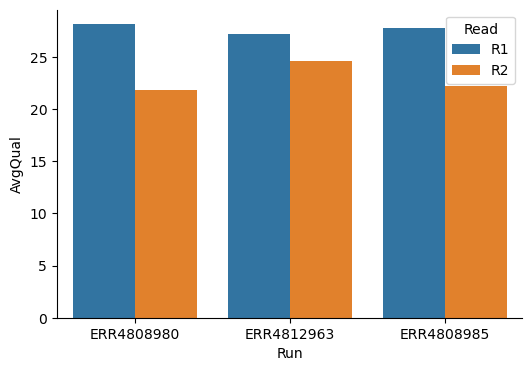

In [5]:
fig, ax = plt.subplots(figsize=(len(df_seq_stats), 4))

sns.barplot(data=df_seq_stats,
            x='Run',
            y='AvgQual',
            hue='Read',
            hue_order=['R1', 'R2'],
           )

sns.despine()
plt.show()

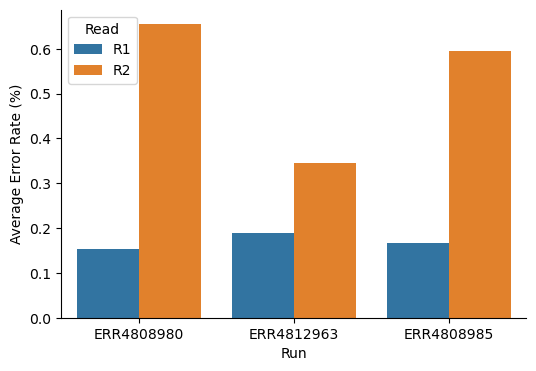

In [9]:
# Q = -10 * log_10(P)
# P = 10^(-Q / 10)
df_seq_stats['Error_Rate_Percent'] = (10 ** (-df_seq_stats['AvgQual'] / 10)) * 100

fig, ax = plt.subplots(figsize=(len(df_seq_stats), 4))

sns.barplot(data=df_seq_stats,
            x='Run',
            y='Error_Rate_Percent',
            hue='Read',
            hue_order=['R1', 'R2'],
           )

plt.ylabel('Average Error Rate (%)')

sns.despine()
plt.show()

# 4. Taxonomic Classification

For taxonomic classification, we will use the Kraken suite of tools for metagenomic classification from Johns Hopkins. 

These tools use exact-matching of read k-mers against a Kraken database of k-mers from existing genomes.

For full read classification, kraken tools are preferred over other methods (like MetaPhlan) because they contain genome-wide k-mers, rather than only k-mers that distinguish between taxa. So they can be used for both sample-level classification and read-level classification.

Kraken2, the software we will be using, is also very fast.

More about it here:

<ul>
    <li><a href="https://www.nature.com/articles/s41596-022-00738-y" target="_blank">Metagenome analysis using the Kraken software suite
</a></li>
    <li><a href="https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1891-0" target="_blank">Improved metagenomic analysis with Kraken 2</a></li>
</ul>

Kraken2 produces 2 output files: 

1. a report summarizing the counts and percentages of reads that map to each taxon
2. a large file of the taxon that each read was classified as

<b>In each kraken report (`kraken_report.txt`), there are 6 columns:</b>

1. Percentage of Reads: Percentage of total classified reads assigned to this taxon (including sub-taxa).
2. Number of Reads: Number of reads assigned directly to this taxon (not including sub-taxa).
3. Number of Reads (Including Sub-taxa): Number of reads assigned to this taxon plus all its sub-taxa.
4. Taxonomic Rank Code: Single-letter code indicating taxonomic rank (e.g., U = Unclassified, R = Root, D = Domain, P = Phylum, C = Class, O = Order, F = Family, G = Genus, S = Species).
5. NCBI Taxonomic ID: The NCBI Taxonomy ID for this taxon.
6. Taxon Name: The name of the taxon, indented with leading spaces to show the hierarchy.

<b>In each kraken classifications file (`kraken_classifications.txt.gz`), there are 5 columns:</b>

1. C/U: Whether each read was classified (C) or unclassified (U).
2. Read Name
3. NCBI Taxonomic ID: The NCBI Taxonomy ID that the read was assigned to. If a read was unclassified, tha taxid is 0.
4. Read Length
5. String of the assignments for each k-mer within the read. `1763:15` means that 15 k-mers were classified to taxid 1763. For paired-end data, the `|:|` character separates the classifications for the first and second reads. `A:10` indicates that 10 k-mers had ambiguous nucleotides (Ns).

## Questions

### iii. What percent of reads map to the following groups in each sample:

<ul>
<li><i>Mycobacterium</i> genus</li>
<li><i>Homo sapiens</i></li>
<li>Unclassified</li>
</ul>

### iv. Where do you think the unclassified reads come from?

### v. What is the most common bacterial contaminant (not in the <i>Mycobacterium</i> genus) in each sample?

### vi. In any of the samples, is the most common genus not <i>Mycobacterium</i>?

### vii. Where do you think these bacterial contaminants come from? Are they biological or technical?

There was an interesting <a href="https://pmc.ncbi.nlm.nih.gov/articles/PMC4228153/" target="_blank">paper</a> published some years ago about contaminating DNA found in PCR and DNA library prep reagents. Many of the organisms from which this DNA originates are commensal bacteria or ubiquitous environmental bacteria.

In [10]:
kraken_fNames = glob.glob(f"{out_dir}/results/*/kraken/kraken_report.txt")
kraken_classification_fNames = glob.glob(f"{out_dir}/results/*/kraken/kraken_classifications.txt.gz")

# check that there are 3 files of each type -- the report and the full classifications
len(kraken_fNames), len(kraken_classification_fNames)

(3, 3)

In [12]:
df_kraken_summary = pd.DataFrame(columns=['SampleID', 'Unclassified_Perc', 'Mycobacteria_Perc', 'Second_Highest_Genus', 'Second_Highest_Genus_Perc', 'Second_Highest_Species', 'Second_Highest_Species_Perc', 'Human_Perc'])
i = 0

for i, fName in enumerate(kraken_fNames):

    sample = re.search(r"\bERR\w+\d+\b", fName)[0]
    
    df_kraken_report = pd.read_csv(fName, sep='\t', header=None)
    df_kraken_report.columns = ['Percent_Reads', 'Num_Reads_Children', 'Num_Reads', 'Tax_Level', 'Tax_ID', 'Tax_Name']
    df_kraken_report = df_kraken_report.query("Num_Reads > 0").reset_index(drop=True)

    unclassified_reads_percent = df_kraken_report.query("Tax_Level=='U'").Percent_Reads.values[0]
    
    mycobacteria_reads_percent = df_kraken_report.query("Tax_ID==1763").Percent_Reads.values[0]

    second_highest_genus = df_kraken_report.query("Tax_Level=='G' & ~Tax_Name.str.contains('Mycobacter')").sort_values("Percent_Reads", ascending=False).Tax_Name.values[0]
    second_highest_genus_reads_percent = df_kraken_report.query("Tax_Name==@second_highest_genus").Percent_Reads.values[0]

    second_highest_species = df_kraken_report.query("Tax_Level=='S' & ~Tax_Name.str.contains('Mycobacter')").sort_values("Percent_Reads", ascending=False).Tax_Name.values[0]
    second_highest_species_reads_percent = df_kraken_report.query("Tax_Name==@second_highest_species").Percent_Reads.values[0]

    human_reads_percent = df_kraken_report.query("Tax_Name.str.contains('Homo sapiens')").Percent_Reads.values[0]
    
    df_kraken_summary.loc[i, :] = [sample, unclassified_reads_percent, mycobacteria_reads_percent, second_highest_genus.lstrip().rstrip(), second_highest_genus_reads_percent, second_highest_species.lstrip().rstrip(), second_highest_species_reads_percent, human_reads_percent]
    i += 1

In [13]:
df_kraken_summary

,SampleID,Unclassified_Perc,Mycobacteria_Perc,Second_Highest_Genus,Second_Highest_Genus_Perc,Second_Highest_Species,Second_Highest_Species_Perc,Human_Perc
0,ERR4808980,6.35,32.9,Brevibacillus,59.95,Brevibacillus agri,59.74,0.01
1,ERR4812963,0.49,58.84,Escherichia,17.96,Escherichia coli,15.0,0.03
2,ERR4808985,0.1,78.89,Staphylococcus,20.76,Staphylococcus epidermidis,10.26,0.0


# 5. Write your own rule

Let's say we want to further investigate the unclassified reads to determine if they are something novel not represented in the standard Kraken database or if they are due to poor quality sequencing. The first step would be to gather the unclassified reads and their associated quality scores.

## Questions

### viii. How many reads are in each of the 6 FASTQ files (after the kraken-classification step)?

Verify that the R1 and R2 files of each sample have the same numbers of reads.

### ix. Extract the 1000th read (by count) from each file and print it and its name out.

Do not use any tools other than Python (Biopython) and bash.

```bash
# The Nth read name is the (N - 1) * 4 + 1 line, so the 1000th line is the 999 * 4 + 1 = 3997 line
# to get the Nth line of a gzipped file and the following 3 lines:
N=3997
fName="results/ERR4808980/fastp/ERR4808980.R1.trimmed.fastq.gz"

# gunzip unzips a gzipped file. -c flag means to NOT change the original file
# sed -n "${N}p" finds the Nth line. Then we extract up to the (N+3)th line
gunzip -c $fName | sed -n "${N},$((N+3))p"
```

### x. Write a rule to extract the unclassified reads for each sample and write them to new FASTQ files

The `seqtk` <a href="https://github.com/lh3/seqtk" target="_blank">package</a> will be useful because it can extract reads by name. This package has already been installed in the `read_QC` environment.

There should be two FASTQ files, one for the forward reads and one for the reverse. Add the rule to your `rules.smk` file. Update your `snakefile` accordingly and rerun the workflow. 

Notice that the workflow will only run the new rule because the previous rules nor their output files have been changed.